In [1]:
import sys
import torch


sys.path.append("..")

from data import get_task, get_dataloader
from helpers import ROOT_DIR
from models.gpt2 import GPT2Editor

torch.cuda.manual_seed(42)


%env CUDA_VISIBLE_DEVICES=2
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
def compute_position_ids(attn_mask: torch.LongTensor) -> torch.Tensor:
    unmasked_len = attn_mask.sum(-1, keepdim=True)
    position_ids = (
        torch.arange(0, attn_mask.shape[-1], device=attn_mask.device)
        .unsqueeze(0)
        .repeat(unmasked_len.shape[0], 1)
    )
    position_ids -= unmasked_len
    position_ids[position_ids < 0] = 0
    return position_ids

In [7]:
attn_mask = torch.cat((torch.zeros(2,4), torch.ones(2,4)), dim=-1).to(torch.long)

position_ids = compute_position_ids(attn_mask)
print(attn_mask)
print(position_ids)

tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1]])
tensor([[0, 0, 0, 0, 0, 1, 2, 3],
        [0, 0, 0, 0, 0, 1, 2, 3]])


In [2]:
from omegaconf import DictConfig

cfg = DictConfig(
    {
        "model": {"name_or_path": "gpt2", "max_length": 512},
        "task": {
            "name": "wikipedia",
            "followup_char_limit": 500,
            "editor_token_limit": 50,
        },
        "train": {"train_batch_size": 1, "validation_batch_size": 1},
        "data": {
            "test_split": 0.1,
            "val_split": 0.1,
            "n_examples": 1000,
            "train_batch_size": 2,
            "val_batch_size": 2,
        },
        "seed": 42,
    }
)

ds = get_task(cfg, "wikipedia", "train")

dl = get_dataloader(ds, cfg, "train")

Loading dataset from disk:   0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer

batch = next(iter(dl))

tok = AutoTokenizer.from_pretrained(cfg.model.name_or_path)

for k, v in batch.items():
    if "input_ids" in k:
        print(k, v)
        # print(k, v.size(), tok.batch_decode(v, skip_special_tokens=True))

editor_input_ids tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256

In [4]:
from models.gpt2 import GPT2EditorConfig

editor_model = GPT2Editor(GPT2EditorConfig()).cuda()

In [5]:
from helpers import slice_and_move_batch_for_device

batch = next(iter(dl))
out = editor_model(**slice_and_move_batch_for_device(batch, 0, 1))

In [6]:
{k: v.shape for k, v in batch.items()}

{'editor_input_ids': torch.Size([1, 512]),
 'editor_attention_mask': torch.Size([1, 512]),
 'target_input_ids': torch.Size([1, 50]),
 'target_attention_mask': torch.Size([1, 50])}

In [7]:
editor_model.target_model.config.eos_token_id

50256

In [29]:
from train_utils import compute_ce_loss, compute_kl_loss

with torch.no_grad():
    # loss_ce = compute_ce_loss(editor_model, batch, 0, 1)
    loss_kl, _, _ = compute_kl_loss(editor_model, batch, 0, 1)

EDITED TARGET LOGITS SHAPE torch.Size([1, 50, 50257])
BATCH TARGET ATTN MASK tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')
BATCH TARGET IDS tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256,   464,  4365,   373,  2957,   416,  1294,  4986,   286,
          5947,  5199, 22586, 47848,   290,  3611, 28276,   360,    13,  8121,
            11,   262, 12787,   286,   262, 16798, 18733,   286,  9983,   492]],
       device='cuda:0')
BATCH EDITED IDS tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256

In [24]:
target_logps.shape
edited_target_logps.shape

torch.Size([28, 50257])

In [27]:
target_logps.sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

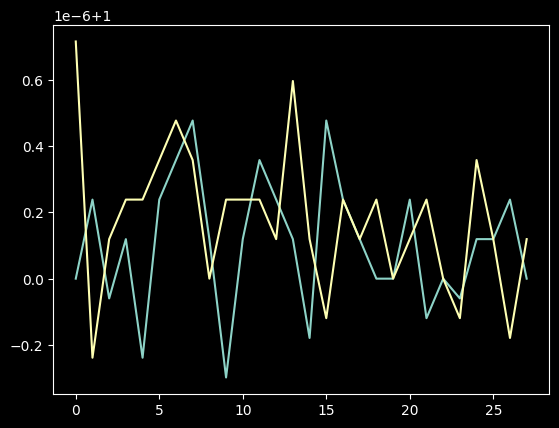

In [20]:
import matplotlib.pyplot as plt

plt.plot(target_logps.sum(-1).detach().cpu().numpy())
plt.plot(edited_target_logps.sum(-1).detach().cpu().numpy())